Best so far but old features

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [22]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [23]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [24]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [25]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [26]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [27]:
def create_combined_model_with_prot_t5(seq_length=33, struct_features=12, struct_window=0):
    regularizer = tf.keras.regularizers.l2(0.01)
    
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', 
                                 kernel_regularizer=regularizer, 
                                 name='seq_features')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # Structure track
    # Structure track with adaptive dense layer size
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)

    struct_positions = 1 + (2 * struct_window)
    total_struct_features = struct_positions * struct_features
    
    # Make dense layer size proportional to input features
    struct_dense_size = min(total_struct_features * 2, 128)  # or another scaling rule
        
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256, kernel_regularizer=regularizer)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu',
                                     kernel_regularizer=regularizer)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.BatchNormalization()(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.5)(x_prot_t5)

    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(3, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 2:3])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct, weighted_prot_t5])

    # Final layers with more regularization
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32, activation='relu', 
                            kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, struct_input, prot_t5_input], outputs=outputs)
    
    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1]),
                'prot_t5': float(normalized[2])
            }
        return {'sequence': 0.33, 'structure': 0.33, 'prot_t5': 0.34}

    model.get_track_weights = get_track_weights
    return model

In [28]:
def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/old data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/old data/processed_data_test_after.csv")
    
    # Load ProtT5 embeddings
    print("Loading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data
    print("Aligning data...")
    X_train_prot_t5, train_df_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_df_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    # Prepare other data
    X_train_seq = prepare_sequence_data(train_df_aligned)
    X_test_seq = prepare_sequence_data(test_df_aligned)
    X_train_struct = prepare_structure_data(train_df_aligned)
    X_test_struct = prepare_structure_data(test_df_aligned)
    
    y_train = train_df_aligned['label'].values
    y_test = test_df_aligned['label'].values
    
    # Shuffle training data
    shuffle_idx = np.random.RandomState(42).permutation(len(y_train))
    X_train_seq = X_train_seq[shuffle_idx]
    X_train_struct = X_train_struct[shuffle_idx]
    X_train_prot_t5 = X_train_prot_t5[shuffle_idx]
    y_train = y_train[shuffle_idx]
    
    # Shuffle test data
    shuffle_idx_test = np.random.RandomState(42).permutation(len(y_test))
    X_test_seq = X_test_seq[shuffle_idx_test]
    X_test_struct = X_test_struct[shuffle_idx_test]
    X_test_prot_t5 = X_test_prot_t5[shuffle_idx_test]
    y_test = y_test[shuffle_idx_test]
    
    # Print class distribution after shuffling
    print("\nTraining set distribution (after shuffling):")
    print(pd.Series(y_train).value_counts())
    print("\nTest set distribution (after shuffling):")
    print(pd.Series(y_test).value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_train_prot_t5: {X_train_prot_t5.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"X_test_prot_t5: {X_test_prot_t5.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model_with_prot_t5(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx], X_train_prot_t5[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct, X_test_prot_t5])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"Structure weight: {final_weights['structure']:.4f}")
        print(f"ProtT5 weight: {final_weights['prot_t5']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    avg_prot_t5_weight = np.mean([w['prot_t5'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    std_prot_t5_weight = np.std([w['prot_t5'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
    print(f"ProtT5 weight: {avg_prot_t5_weight:.4f} ± {std_prot_t5_weight:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Struct window:  0
Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution (after shuffling):
1    4592
0    4258
Name: count, dtype: int64

Test set distribution (after shuffling):
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_train_prot_t5: (8850, 1024)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
X_test_prot_t5: (2737, 1024)
y_train: (8850,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.5106 - loss: 8.0328 - val_accuracy: 0.5859 - val_loss: 5.7471 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.5301 - loss: 5.2569 - val_accuracy: 0.5836 - val_loss: 3.6371 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.5763 - loss: 3.2769 - val_accuracy: 0.6819 - val_loss: 2.2789 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - accuracy: 0.6517 - loss: 2.0774 - val_accuracy: 0.6847 - val_loss: 1.5787 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 32s 142ms/step - accuracy: 0.6905 - loss: 1.4655 - val_accuracy: 0.7006 - val_loss: 1.1917 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.7042 - loss: 1.1489 - val_accuracy: 0.6825 - val_loss: 1.0331 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.7

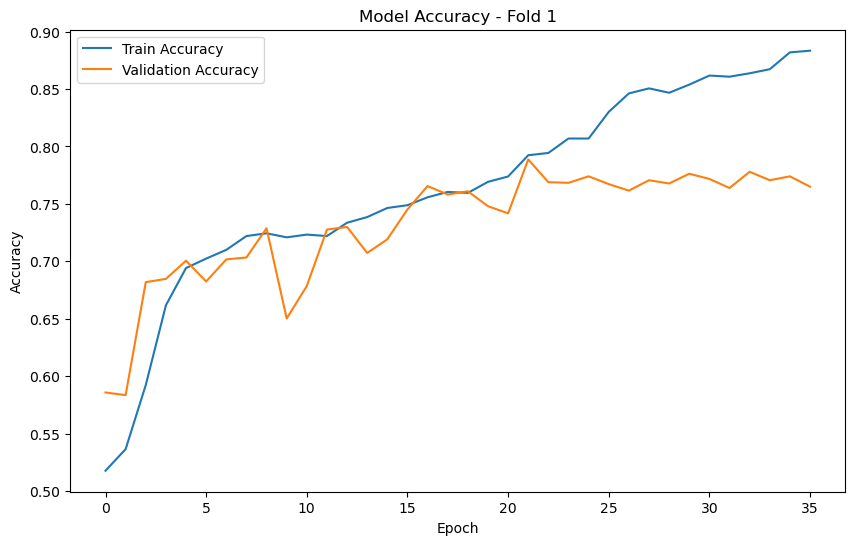

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Fold 1 Results:
Accuracy: 0.7718
Balanced Accuracy: 0.7681
MCC: 0.5386
Sensitivity: 0.8091
Specificity: 0.7270

Learned track weights for fold 1:
Sequence weight: 0.3914
Structure weight: 0.2826
ProtT5 weight: 0.3260

Fold 2/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.5202 - loss: 7.9229 - val_accuracy: 0.5412 - val_loss: 5.4905 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.5376 - loss: 4.9220 - val_accuracy: 0.6226 - val_loss: 3.2678 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.6117 - loss: 2.9136 - val_accuracy: 0.6701 - val_loss: 2.0263 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.6635 - loss: 1.8530 - val_accuracy: 0.6316 - val_loss: 1.4387 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6957 - loss: 1.3191 - val_accuracy: 0.7119 - val_loss: 1.1096 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7065 - loss: 1.0851 - val_accuracy: 0.6723 - val_loss: 0.9949 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7

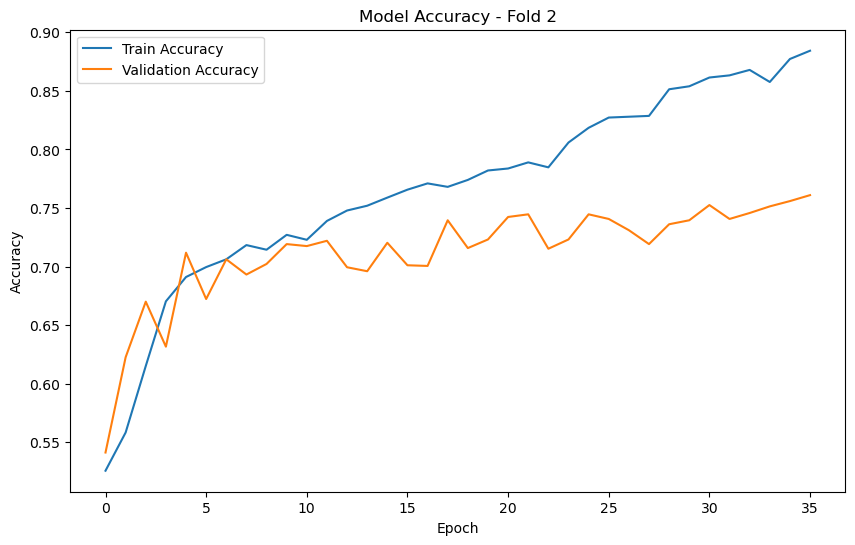

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 2 Results:
Accuracy: 0.7525
Balanced Accuracy: 0.7529
MCC: 0.5048
Sensitivity: 0.7479
Specificity: 0.7578

Learned track weights for fold 2:
Sequence weight: 0.4406
Structure weight: 0.2521
ProtT5 weight: 0.3073

Fold 3/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 128ms/step - accuracy: 0.5263 - loss: 8.0043 - val_accuracy: 0.5282 - val_loss: 5.7436 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.5841 - loss: 5.1706 - val_accuracy: 0.5904 - val_loss: 3.6042 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.6437 - loss: 3.2181 - val_accuracy: 0.6356 - val_loss: 2.2777 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.6780 - loss: 2.0711 - val_accuracy: 0.6734 - val_loss: 1.5792 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.6972 - loss: 1.4767 - val_accuracy: 0.6831 - val_loss: 1.2286 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 127ms/step - accuracy: 0.7069 - loss: 1.1776 - val_accuracy: 0.6944 - val_loss: 1.0322 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.7

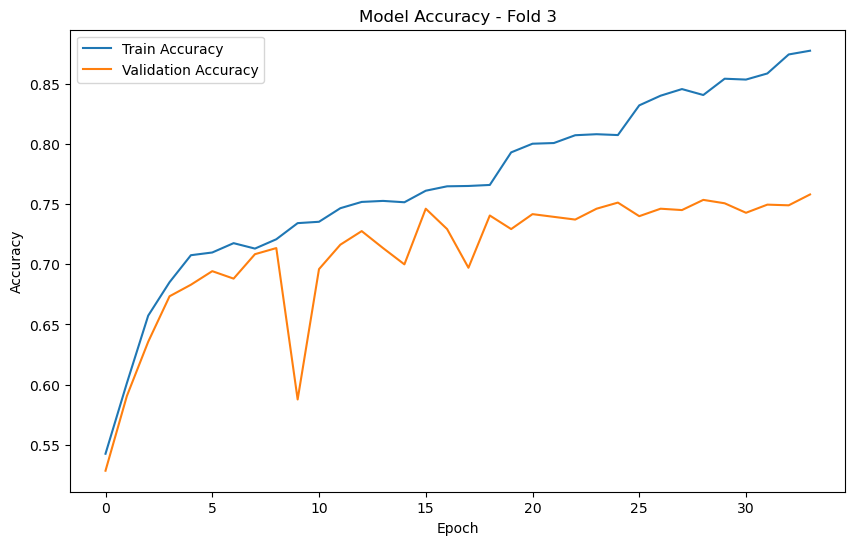

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 3 Results:
Accuracy: 0.7537
Balanced Accuracy: 0.7525
MCC: 0.5227
Sensitivity: 0.8791
Specificity: 0.6260

Learned track weights for fold 3:
Sequence weight: 0.3876
Structure weight: 0.3077
ProtT5 weight: 0.3047

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.5055 - loss: 8.1014 - val_accuracy: 0.5672 - val_loss: 5.8027 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.5586 - loss: 5.2757 - val_accuracy: 0.6073 - val_loss: 3.5870 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.5909 - loss: 3.2334 - val_accuracy: 0.6390 - val_loss: 2.2659 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6306 - loss: 2.0921 - val_accuracy: 0.6520 - val_loss: 1.5815 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6793 - loss: 1.4746 - val_accuracy: 0.7034 - val_loss: 1.2021 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6755 - loss: 1.1702 - val_accuracy: 0.7040 - val_loss: 1.0188 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6

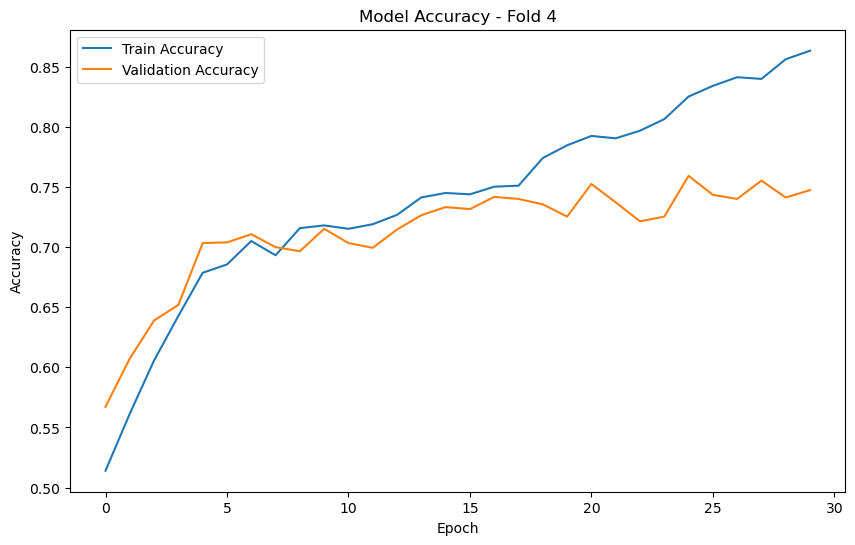

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 4 Results:
Accuracy: 0.7593
Balanced Accuracy: 0.7591
MCC: 0.5191
Sensitivity: 0.7327
Specificity: 0.7856

Learned track weights for fold 4:
Sequence weight: 0.4020
Structure weight: 0.2863
ProtT5 weight: 0.3117

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 38s 124ms/step - accuracy: 0.5066 - loss: 8.2054 - val_accuracy: 0.4994 - val_loss: 6.0996 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.5439 - loss: 5.6337 - val_accuracy: 0.5989 - val_loss: 4.0754 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.5758 - loss: 3.7440 - val_accuracy: 0.6226 - val_loss: 2.7190 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6268 - loss: 2.5568 - val_accuracy: 0.6379 - val_loss: 1.9324 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6716 - loss: 1.7826 - val_accuracy: 0.6927 - val_loss: 1.4356 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7086 - loss: 1.3582 - val_accuracy: 0.7068 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7

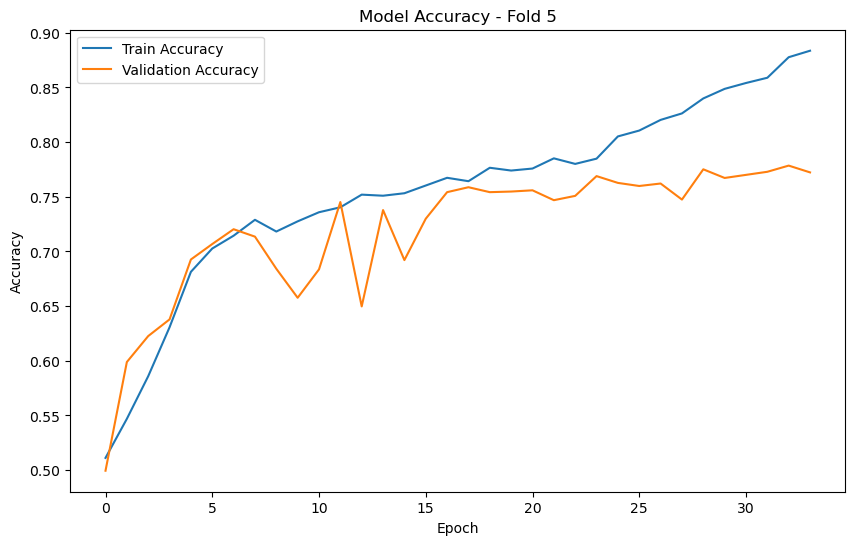

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 5 Results:
Accuracy: 0.7751
Balanced Accuracy: 0.7713
MCC: 0.5586
Sensitivity: 0.8821
Specificity: 0.6604

Learned track weights for fold 5:
Sequence weight: 0.4367
Structure weight: 0.2750
ProtT5 weight: 0.2883

Average track weights across folds:
Sequence weight: 0.4117 ± 0.0226
Structure weight: 0.2808 ± 0.0180
ProtT5 weight: 0.3076 ± 0.0121

Average Cross-validation Results:
ACC: 0.7625 ± 0.0093
BALANCED_ACC: 0.7608 ± 0.0077
MCC: 0.5288 ± 0.0184
SN: 0.8102 ± 0.0629
SP: 0.7114 ± 0.0597

Final Test Set Results:
Accuracy: 0.7329
Balanced Accuracy: 0.7821
MCC: 0.3401
Sensitivity: 0.8417
Specificity: 0.7225
Confusion Matrix:
[[1804  693]
 [  38  202]]
##################################################
Struct window:  1
Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution (after shuffling):
1    4592
0    4258
Name: count, dtype: int64

Test set distribution (after shu

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.5201 - loss: 8.2331 - val_accuracy: 0.6384 - val_loss: 5.9392 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.5516 - loss: 5.4999 - val_accuracy: 0.6740 - val_loss: 3.8313 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.6088 - loss: 3.5027 - val_accuracy: 0.6932 - val_loss: 2.4610 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6645 - loss: 2.2569 - val_accuracy: 0.7102 - val_loss: 1.6751 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6857 - loss: 1.5605 - val_accuracy: 0.7073 - val_loss: 1.2542 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7109 - loss: 1.1640 - val_accuracy: 0.7011 - val_loss: 1.0197 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7

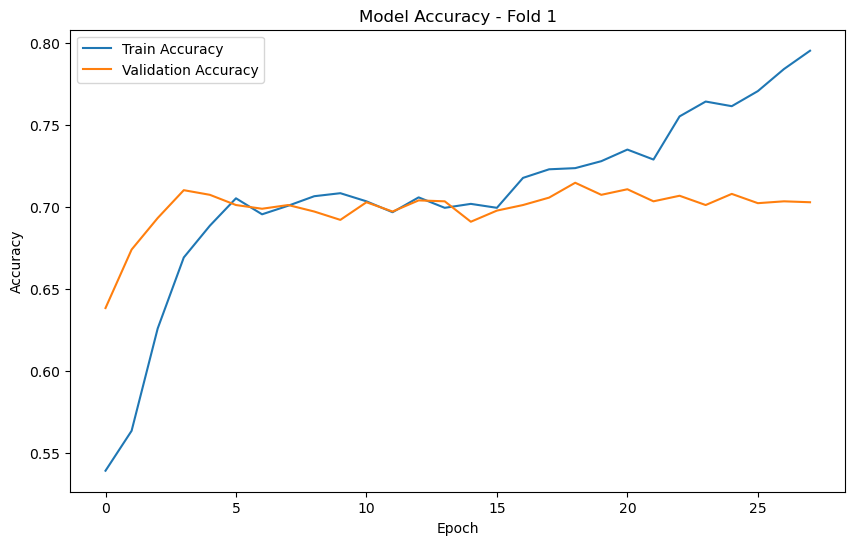

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 1 Results:
Accuracy: 0.7068
Balanced Accuracy: 0.6986
MCC: 0.4054
Sensitivity: 0.7905
Specificity: 0.6067

Learned track weights for fold 1:
Sequence weight: 0.3119
Structure weight: 0.3138
ProtT5 weight: 0.3743

Fold 2/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - accuracy: 0.4983 - loss: 7.9690 - val_accuracy: 0.5266 - val_loss: 5.4072 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.5405 - loss: 4.8343 - val_accuracy: 0.5910 - val_loss: 3.1970 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6078 - loss: 2.8573 - val_accuracy: 0.6893 - val_loss: 1.9410 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6956 - loss: 1.7576 - val_accuracy: 0.6960 - val_loss: 1.3391 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7106 - loss: 1.2438 - val_accuracy: 0.6774 - val_loss: 1.0717 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.7143 - loss: 1.0181 - val_accuracy: 0.6921 - val_loss: 0.9171 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7

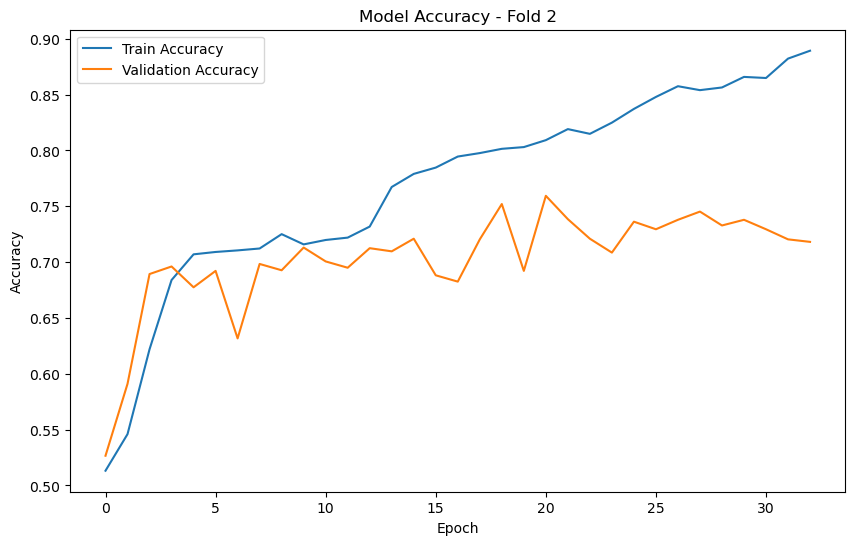

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 2 Results:
Accuracy: 0.7452
Balanced Accuracy: 0.7479
MCC: 0.4957
Sensitivity: 0.7043
Specificity: 0.7916

Learned track weights for fold 2:
Sequence weight: 0.3508
Structure weight: 0.3271
ProtT5 weight: 0.3222

Fold 3/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.5098 - loss: 8.0756 - val_accuracy: 0.5260 - val_loss: 5.6797 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.5658 - loss: 5.1477 - val_accuracy: 0.6169 - val_loss: 3.4705 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6359 - loss: 3.1129 - val_accuracy: 0.6492 - val_loss: 2.1746 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6698 - loss: 1.9780 - val_accuracy: 0.6282 - val_loss: 1.5390 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7008 - loss: 1.3860 - val_accuracy: 0.7090 - val_loss: 1.1482 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6947 - loss: 1.1160 - val_accuracy: 0.7068 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.7

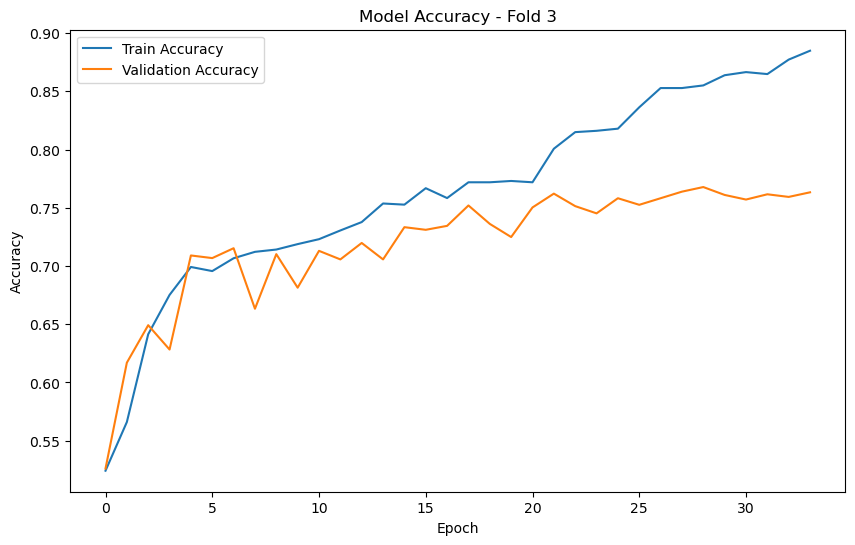

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 3 Results:
Accuracy: 0.7678
Balanced Accuracy: 0.7677
MCC: 0.5356
Sensitivity: 0.7816
Specificity: 0.7537

Learned track weights for fold 3:
Sequence weight: 0.3656
Structure weight: 0.3211
ProtT5 weight: 0.3132

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - accuracy: 0.5075 - loss: 8.0006 - val_accuracy: 0.5542 - val_loss: 5.5089 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.5589 - loss: 4.9333 - val_accuracy: 0.6198 - val_loss: 3.2587 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6117 - loss: 2.9318 - val_accuracy: 0.6876 - val_loss: 1.9985 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6522 - loss: 1.8478 - val_accuracy: 0.7119 - val_loss: 1.3692 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6933 - loss: 1.3157 - val_accuracy: 0.7164 - val_loss: 1.0839 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6984 - loss: 1.0586 - val_accuracy: 0.7034 - val_loss: 0.9540 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7

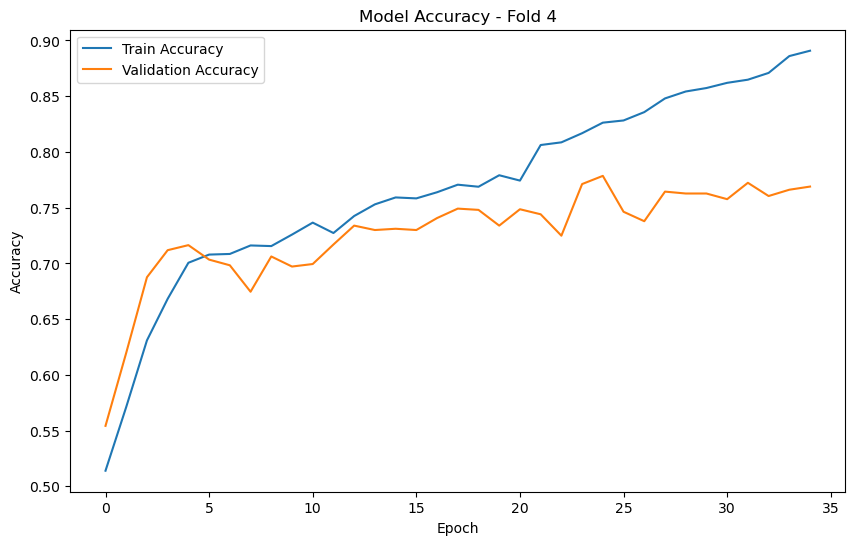

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 4 Results:
Accuracy: 0.7627
Balanced Accuracy: 0.7634
MCC: 0.5378
Sensitivity: 0.8658
Specificity: 0.6611

Learned track weights for fold 4:
Sequence weight: 0.3746
Structure weight: 0.3130
ProtT5 weight: 0.3125

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.5139 - loss: 8.0507 - val_accuracy: 0.5672 - val_loss: 5.6345 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.5369 - loss: 5.1035 - val_accuracy: 0.6299 - val_loss: 3.4014 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6028 - loss: 3.0656 - val_accuracy: 0.6610 - val_loss: 2.1302 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6580 - loss: 1.9401 - val_accuracy: 0.6927 - val_loss: 1.4632 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6923 - loss: 1.3625 - val_accuracy: 0.6966 - val_loss: 1.1247 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7059 - loss: 1.0606 - val_accuracy: 0.6836 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.7

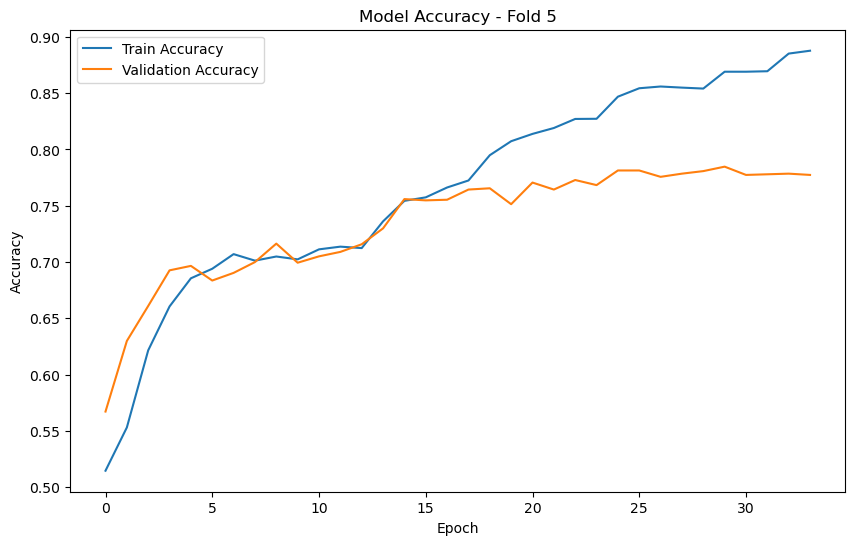

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 5 Results:
Accuracy: 0.7808
Balanced Accuracy: 0.7784
MCC: 0.5634
Sensitivity: 0.8472
Specificity: 0.7096

Learned track weights for fold 5:
Sequence weight: 0.3539
Structure weight: 0.3258
ProtT5 weight: 0.3203

Average track weights across folds:
Sequence weight: 0.3514 ± 0.0215
Structure weight: 0.3201 ± 0.0059
ProtT5 weight: 0.3285 ± 0.0232

Average Cross-validation Results:
ACC: 0.7527 ± 0.0256
BALANCED_ACC: 0.7512 ± 0.0281
MCC: 0.5076 ± 0.0555
SN: 0.7979 ± 0.0568
SP: 0.7045 ± 0.0655

Final Test Set Results:
Accuracy: 0.7373
Balanced Accuracy: 0.7751
MCC: 0.3338
Sensitivity: 0.8208
Specificity: 0.7293
Confusion Matrix:
[[1821  676]
 [  43  197]]
##################################################
Struct window:  2
Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution (after shuffling):
1    4592
0    4258
Name: count, dtype: int64

Test set distribution (after shu

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.5320 - loss: 8.2167 - val_accuracy: 0.6514 - val_loss: 5.8036 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.5726 - loss: 5.3139 - val_accuracy: 0.6898 - val_loss: 3.6631 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6350 - loss: 3.3568 - val_accuracy: 0.7006 - val_loss: 2.3983 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6654 - loss: 2.1996 - val_accuracy: 0.7119 - val_loss: 1.6417 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7130 - loss: 1.5230 - val_accuracy: 0.7136 - val_loss: 1.2513 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7219 - loss: 1.1964 - val_accuracy: 0.7102 - val_loss: 1.0556 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7

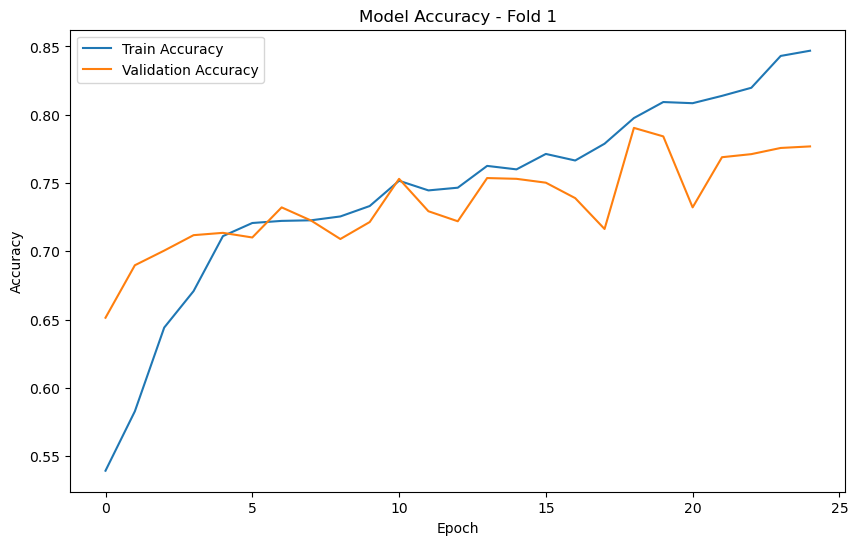

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Fold 1 Results:
Accuracy: 0.7842
Balanced Accuracy: 0.7804
MCC: 0.5637
Sensitivity: 0.8226
Specificity: 0.7382

Learned track weights for fold 1:
Sequence weight: 0.3793
Structure weight: 0.3033
ProtT5 weight: 0.3174

Fold 2/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - accuracy: 0.5177 - loss: 8.0408 - val_accuracy: 0.6175 - val_loss: 5.5668 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.5679 - loss: 5.0446 - val_accuracy: 0.6559 - val_loss: 3.3990 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6329 - loss: 3.0478 - val_accuracy: 0.6910 - val_loss: 2.1003 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6656 - loss: 1.9288 - val_accuracy: 0.6989 - val_loss: 1.4470 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6912 - loss: 1.3462 - val_accuracy: 0.7085 - val_loss: 1.1099 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7100 - loss: 1.0643 - val_accuracy: 0.6932 - val_loss: 0.9694 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7

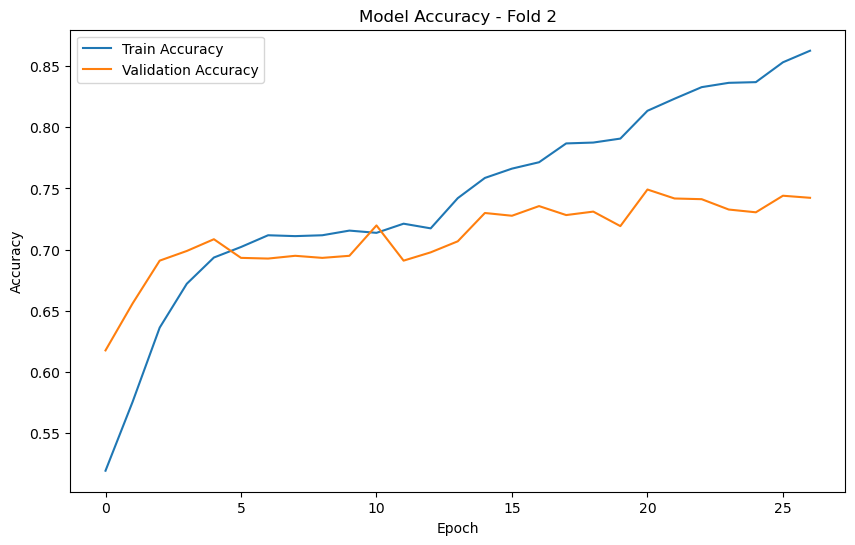

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Fold 2 Results:
Accuracy: 0.7418
Balanced Accuracy: 0.7372
MCC: 0.4812
Sensitivity: 0.8117
Specificity: 0.6627

Learned track weights for fold 2:
Sequence weight: 0.3458
Structure weight: 0.3127
ProtT5 weight: 0.3415

Fold 3/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step - accuracy: 0.5222 - loss: 8.0676 - val_accuracy: 0.5186 - val_loss: 5.6039 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.5818 - loss: 5.0340 - val_accuracy: 0.5977 - val_loss: 3.3827 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6169 - loss: 3.0274 - val_accuracy: 0.6463 - val_loss: 2.0872 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6660 - loss: 1.9076 - val_accuracy: 0.6836 - val_loss: 1.4182 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6985 - loss: 1.3245 - val_accuracy: 0.7068 - val_loss: 1.0864 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7018 - loss: 1.0498 - val_accuracy: 0.7051 - val_loss: 0.9250 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - accuracy: 0.7

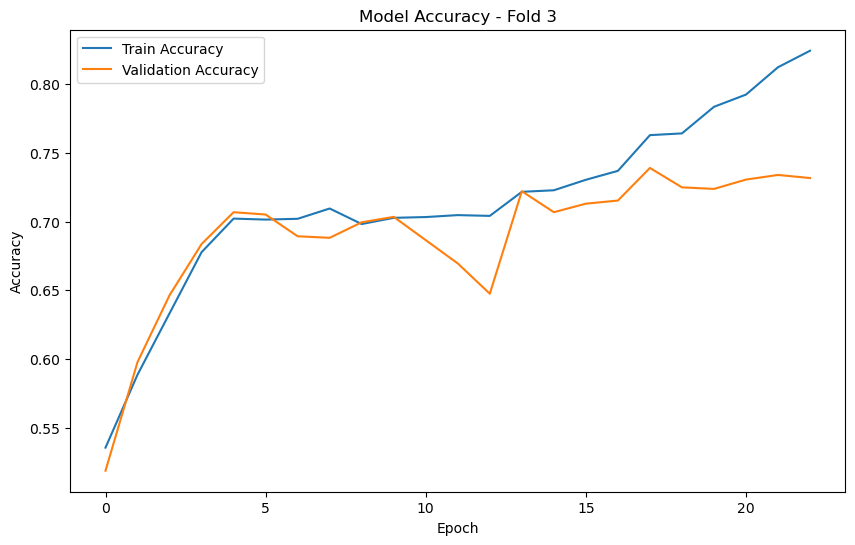

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 3 Results:
Accuracy: 0.7390
Balanced Accuracy: 0.7388
MCC: 0.4780
Sensitivity: 0.7559
Specificity: 0.7218

Learned track weights for fold 3:
Sequence weight: 0.3239
Structure weight: 0.3196
ProtT5 weight: 0.3564

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.5039 - loss: 8.0616 - val_accuracy: 0.5373 - val_loss: 5.5973 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.5867 - loss: 5.0647 - val_accuracy: 0.6373 - val_loss: 3.4413 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.6408 - loss: 3.1013 - val_accuracy: 0.6740 - val_loss: 2.1658 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.6784 - loss: 1.9810 - val_accuracy: 0.7141 - val_loss: 1.4977 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.6898 - loss: 1.4208 - val_accuracy: 0.6915 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6988 - loss: 1.1181 - val_accuracy: 0.7051 - val_loss: 0.9797 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.7

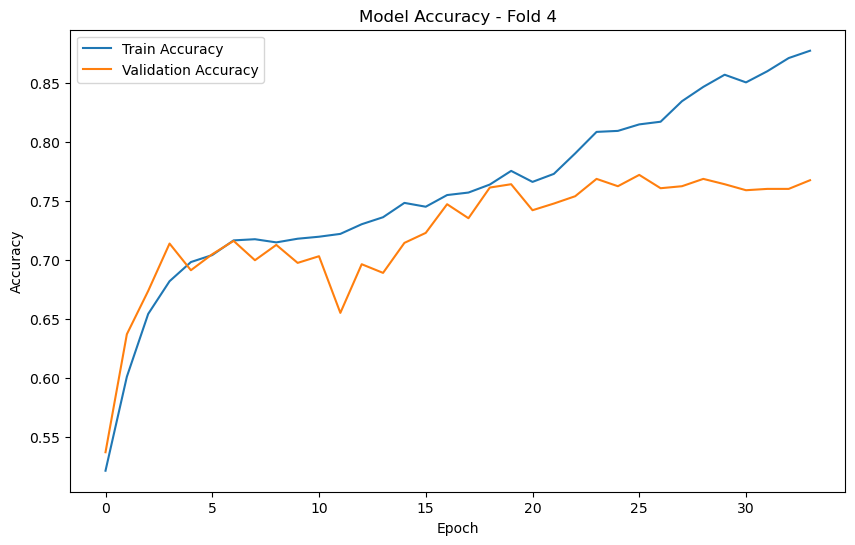

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 4 Results:
Accuracy: 0.7689
Balanced Accuracy: 0.7688
MCC: 0.5383
Sensitivity: 0.7429
Specificity: 0.7946

Learned track weights for fold 4:
Sequence weight: 0.3701
Structure weight: 0.3286
ProtT5 weight: 0.3013

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step - accuracy: 0.5348 - loss: 8.0948 - val_accuracy: 0.6000 - val_loss: 5.7967 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.5713 - loss: 5.3273 - val_accuracy: 0.6480 - val_loss: 3.6714 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - accuracy: 0.6365 - loss: 3.3089 - val_accuracy: 0.6785 - val_loss: 2.3328 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6991 - loss: 2.1166 - val_accuracy: 0.7056 - val_loss: 1.5893 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.6990 - loss: 1.4955 - val_accuracy: 0.7198 - val_loss: 1.2169 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.7274 - loss: 1.1379 - val_accuracy: 0.7119 - val_loss: 1.0168 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7

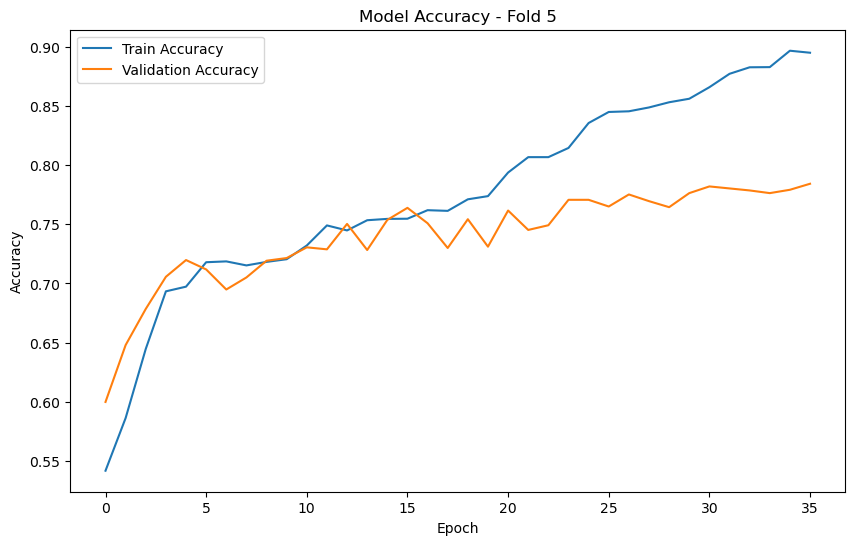

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 5 Results:
Accuracy: 0.7819
Balanced Accuracy: 0.7789
MCC: 0.5681
Sensitivity: 0.8657
Specificity: 0.6920

Learned track weights for fold 5:
Sequence weight: 0.3767
Structure weight: 0.3121
ProtT5 weight: 0.3113

Average track weights across folds:
Sequence weight: 0.3592 ± 0.0212
Structure weight: 0.3153 ± 0.0085
ProtT5 weight: 0.3256 ± 0.0203

Average Cross-validation Results:
ACC: 0.7632 ± 0.0193
BALANCED_ACC: 0.7608 ± 0.0191
MCC: 0.5259 ± 0.0391
SN: 0.7998 ± 0.0451
SP: 0.7219 ± 0.0446

Final Test Set Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7763
MCC: 0.3359
Sensitivity: 0.8208
Specificity: 0.7317
Confusion Matrix:
[[1827  670]
 [  43  197]]
##################################################
Struct window:  3
Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution (after shuffling):
1    4592
0    4258
Name: count, dtype: int64

Test set distribution (after shu

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 129ms/step - accuracy: 0.5261 - loss: 8.0311 - val_accuracy: 0.6141 - val_loss: 5.5533 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.5433 - loss: 5.0302 - val_accuracy: 0.5966 - val_loss: 3.4070 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.5971 - loss: 3.0731 - val_accuracy: 0.6819 - val_loss: 2.1237 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6678 - loss: 1.9429 - val_accuracy: 0.7068 - val_loss: 1.4638 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.6914 - loss: 1.3644 - val_accuracy: 0.7271 - val_loss: 1.1337 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.7135 - loss: 1.0873 - val_accuracy: 0.6605 - val_loss: 1.0348 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.7

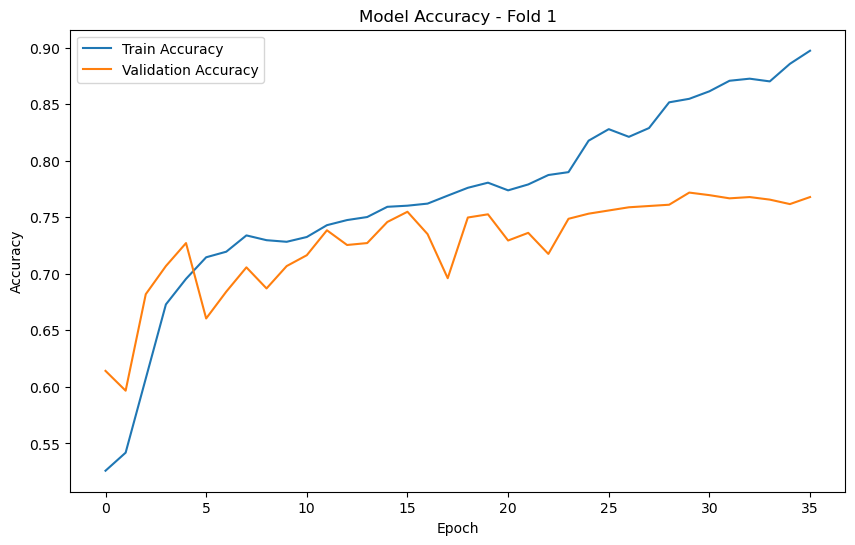

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 1 Results:
Accuracy: 0.7695
Balanced Accuracy: 0.7606
MCC: 0.5355
Sensitivity: 0.8600
Specificity: 0.6613

Learned track weights for fold 1:
Sequence weight: 0.3722
Structure weight: 0.3250
ProtT5 weight: 0.3028

Fold 2/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.5256 - loss: 8.0430 - val_accuracy: 0.6220 - val_loss: 5.5480 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.5670 - loss: 5.0138 - val_accuracy: 0.6853 - val_loss: 3.2988 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.6390 - loss: 2.9784 - val_accuracy: 0.6983 - val_loss: 2.0453 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.6829 - loss: 1.8576 - val_accuracy: 0.7073 - val_loss: 1.3899 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.7030 - loss: 1.2979 - val_accuracy: 0.7034 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7058 - loss: 1.0165 - val_accuracy: 0.7006 - val_loss: 0.9003 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7

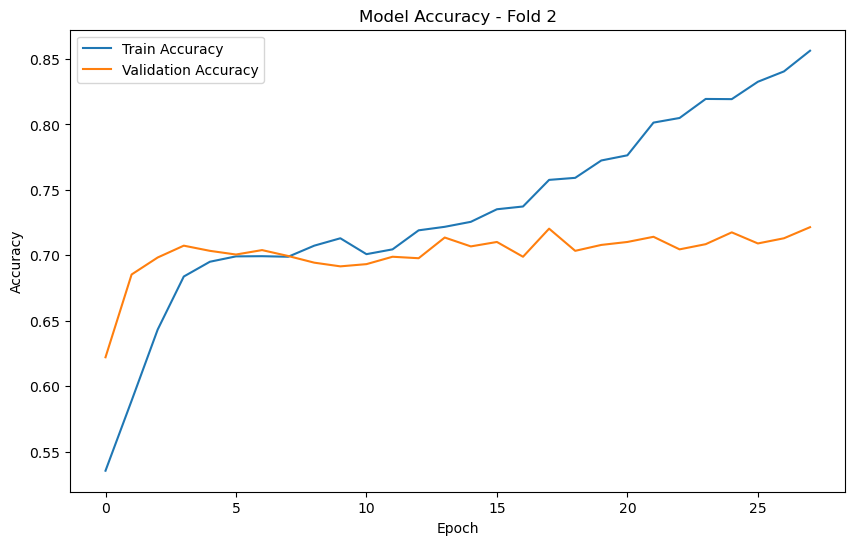

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 2 Results:
Accuracy: 0.7045
Balanced Accuracy: 0.7052
MCC: 0.4097
Sensitivity: 0.6936
Specificity: 0.7169

Learned track weights for fold 2:
Sequence weight: 0.3340
Structure weight: 0.3188
ProtT5 weight: 0.3472

Fold 3/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 48s 173ms/step - accuracy: 0.5145 - loss: 8.2307 - val_accuracy: 0.6271 - val_loss: 5.9226 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - accuracy: 0.5574 - loss: 5.4782 - val_accuracy: 0.6514 - val_loss: 3.7942 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.6190 - loss: 3.4684 - val_accuracy: 0.6989 - val_loss: 2.4198 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.6604 - loss: 2.2562 - val_accuracy: 0.7136 - val_loss: 1.6647 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.6906 - loss: 1.5647 - val_accuracy: 0.7136 - val_loss: 1.2416 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.7156 - loss: 1.1968 - val_accuracy: 0.7000 - val_loss: 1.0624 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - accuracy: 0.7

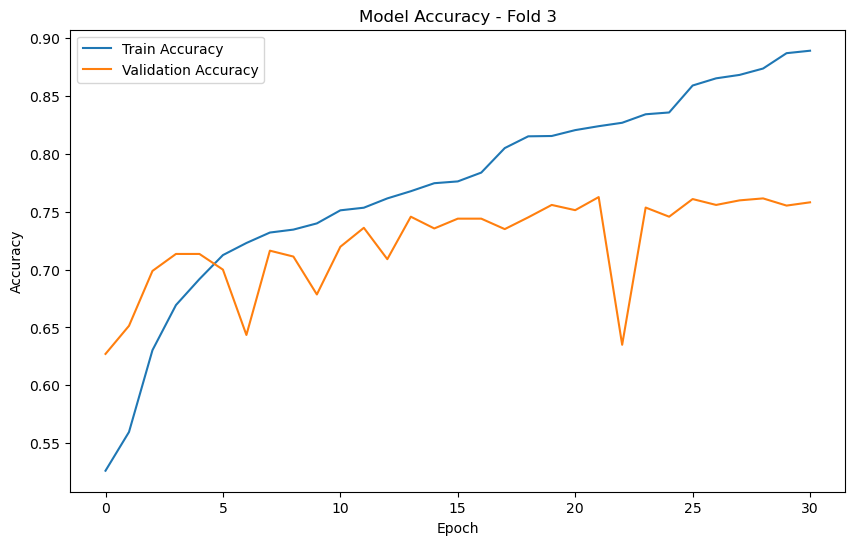

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 3 Results:
Accuracy: 0.7610
Balanced Accuracy: 0.7608
MCC: 0.5223
Sensitivity: 0.7839
Specificity: 0.7377

Learned track weights for fold 3:
Sequence weight: 0.3739
Structure weight: 0.3180
ProtT5 weight: 0.3081

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - accuracy: 0.5109 - loss: 8.2060 - val_accuracy: 0.5797 - val_loss: 5.8418 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.5525 - loss: 5.3300 - val_accuracy: 0.5667 - val_loss: 3.6588 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6037 - loss: 3.3053 - val_accuracy: 0.6757 - val_loss: 2.2861 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.6644 - loss: 2.1081 - val_accuracy: 0.6927 - val_loss: 1.5684 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6869 - loss: 1.4680 - val_accuracy: 0.7006 - val_loss: 1.1868 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7055 - loss: 1.1308 - val_accuracy: 0.6847 - val_loss: 1.0056 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7

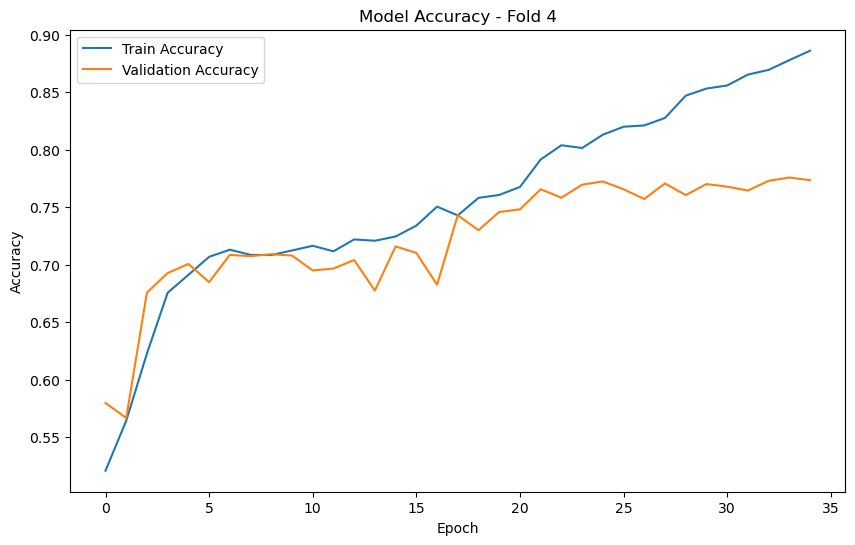

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Fold 4 Results:
Accuracy: 0.7701
Balanced Accuracy: 0.7704
MCC: 0.5438
Sensitivity: 0.8248
Specificity: 0.7160

Learned track weights for fold 4:
Sequence weight: 0.3858
Structure weight: 0.3016
ProtT5 weight: 0.3126

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.5051 - loss: 8.1599 - val_accuracy: 0.5249 - val_loss: 5.7786 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.5276 - loss: 5.2756 - val_accuracy: 0.5718 - val_loss: 3.6036 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.5848 - loss: 3.2714 - val_accuracy: 0.6435 - val_loss: 2.3049 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.6491 - loss: 2.1104 - val_accuracy: 0.6785 - val_loss: 1.5780 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.6904 - loss: 1.4845 - val_accuracy: 0.7153 - val_loss: 1.1956 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.7152 - loss: 1.1460 - val_accuracy: 0.7102 - val_loss: 1.0253 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.7

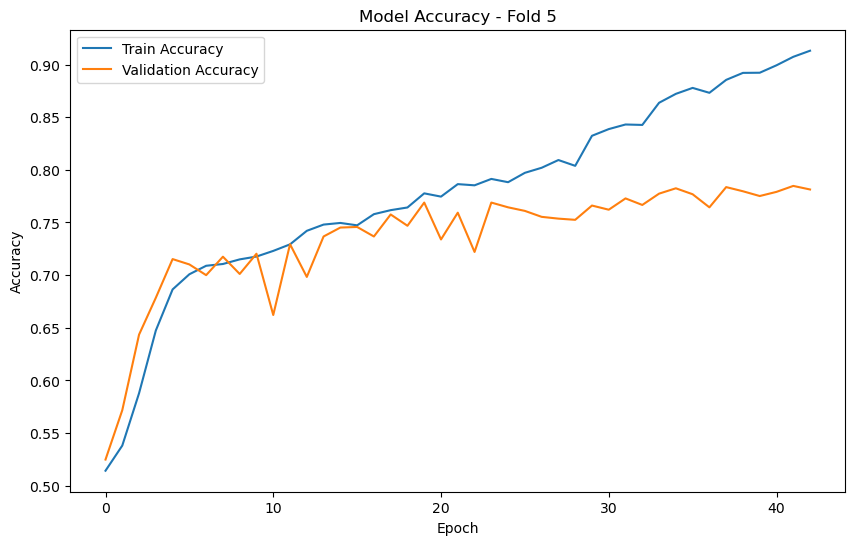

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Fold 5 Results:
Accuracy: 0.7836
Balanced Accuracy: 0.7830
MCC: 0.5665
Sensitivity: 0.8013
Specificity: 0.7646

Learned track weights for fold 5:
Sequence weight: 0.3844
Structure weight: 0.3111
ProtT5 weight: 0.3045

Average track weights across folds:
Sequence weight: 0.3701 ± 0.0188
Structure weight: 0.3149 ± 0.0080
ProtT5 weight: 0.3150 ± 0.0164

Average Cross-validation Results:
ACC: 0.7577 ± 0.0276
BALANCED_ACC: 0.7560 ± 0.0267
MCC: 0.5156 ± 0.0549
SN: 0.7927 ± 0.0557
SP: 0.7193 ± 0.0340

Final Test Set Results:
Accuracy: 0.7289
Balanced Accuracy: 0.7761
MCC: 0.3323
Sensitivity: 0.8333
Specificity: 0.7189
Confusion Matrix:
[[1795  702]
 [  40  200]]
##################################################
Struct window:  4
Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution (after shuffling):
1    4592
0    4258
Name: count, dtype: int64

Test set distribution (after shu

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 49s 131ms/step - accuracy: 0.5204 - loss: 7.9704 - val_accuracy: 0.6271 - val_loss: 5.3219 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.5715 - loss: 4.7642 - val_accuracy: 0.6797 - val_loss: 3.1139 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6415 - loss: 2.7904 - val_accuracy: 0.6825 - val_loss: 1.9485 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6802 - loss: 1.7705 - val_accuracy: 0.6960 - val_loss: 1.3425 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6989 - loss: 1.2646 - val_accuracy: 0.7073 - val_loss: 1.0704 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7097 - loss: 1.0141 - val_accuracy: 0.6915 - val_loss: 0.9553 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7

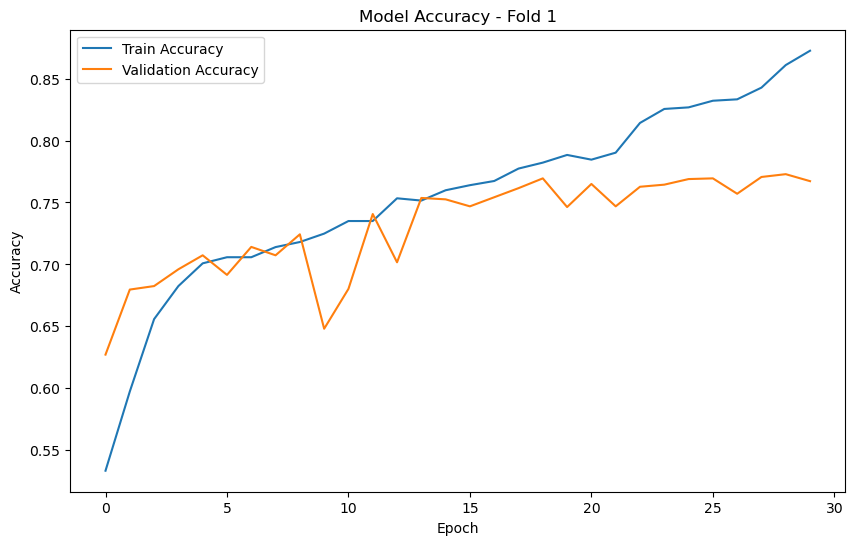

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 1 Results:
Accuracy: 0.7689
Balanced Accuracy: 0.7619
MCC: 0.5329
Sensitivity: 0.8402
Specificity: 0.6836

Learned track weights for fold 1:
Sequence weight: 0.3780
Structure weight: 0.3129
ProtT5 weight: 0.3091

Fold 2/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - accuracy: 0.5300 - loss: 8.0570 - val_accuracy: 0.5949 - val_loss: 5.6499 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.5395 - loss: 5.1564 - val_accuracy: 0.6864 - val_loss: 3.4982 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.6233 - loss: 3.2060 - val_accuracy: 0.7090 - val_loss: 2.2292 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.6713 - loss: 2.0417 - val_accuracy: 0.7119 - val_loss: 1.4966 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - accuracy: 0.6895 - loss: 1.4065 - val_accuracy: 0.7102 - val_loss: 1.1206 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.7103 - loss: 1.0665 - val_accuracy: 0.6944 - val_loss: 0.9552 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 119ms/step - accuracy: 0.7

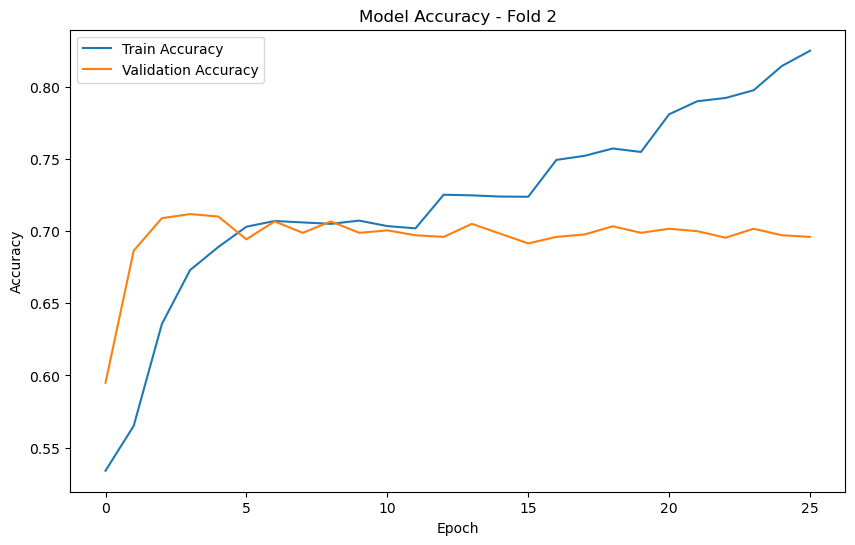

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Fold 2 Results:
Accuracy: 0.7017
Balanced Accuracy: 0.7007
MCC: 0.4013
Sensitivity: 0.7160
Specificity: 0.6855

Learned track weights for fold 2:
Sequence weight: 0.3284
Structure weight: 0.3274
ProtT5 weight: 0.3442

Fold 3/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.5158 - loss: 8.0149 - val_accuracy: 0.6169 - val_loss: 5.5184 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.5511 - loss: 4.9926 - val_accuracy: 0.6718 - val_loss: 3.3248 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.6235 - loss: 3.0168 - val_accuracy: 0.7006 - val_loss: 2.0290 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.6722 - loss: 1.8803 - val_accuracy: 0.7017 - val_loss: 1.3804 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.6940 - loss: 1.2994 - val_accuracy: 0.7073 - val_loss: 1.0819 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.7045 - loss: 1.0307 - val_accuracy: 0.7023 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.7

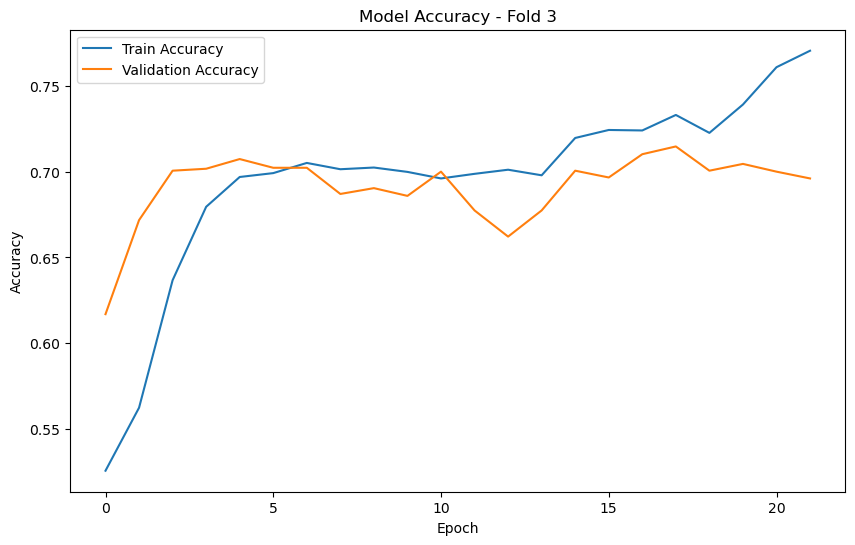

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 3 Results:
Accuracy: 0.7102
Balanced Accuracy: 0.7100
MCC: 0.4203
Sensitivity: 0.7268
Specificity: 0.6933

Learned track weights for fold 3:
Sequence weight: 0.3239
Structure weight: 0.3194
ProtT5 weight: 0.3567

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 129ms/step - accuracy: 0.5120 - loss: 8.0645 - val_accuracy: 0.5198 - val_loss: 5.6198 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.5346 - loss: 5.0673 - val_accuracy: 0.5667 - val_loss: 3.3905 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.6032 - loss: 3.0317 - val_accuracy: 0.6678 - val_loss: 2.0947 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.6584 - loss: 1.9095 - val_accuracy: 0.6960 - val_loss: 1.4126 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.6870 - loss: 1.3403 - val_accuracy: 0.6955 - val_loss: 1.0830 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.6963 - loss: 1.0543 - val_accuracy: 0.6994 - val_loss: 0.9200 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.6

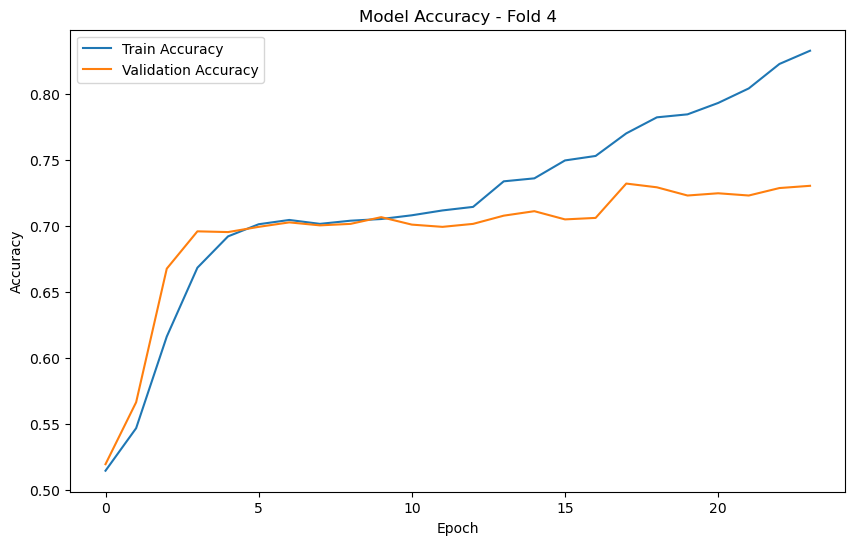

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 4 Results:
Accuracy: 0.7294
Balanced Accuracy: 0.7294
MCC: 0.4589
Sensitivity: 0.7383
Specificity: 0.7205

Learned track weights for fold 4:
Sequence weight: 0.3291
Structure weight: 0.3178
ProtT5 weight: 0.3531

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step - accuracy: 0.5180 - loss: 8.1377 - val_accuracy: 0.6232 - val_loss: 5.6739 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.5642 - loss: 5.1514 - val_accuracy: 0.6480 - val_loss: 3.4708 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.6188 - loss: 3.1553 - val_accuracy: 0.6938 - val_loss: 2.1963 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.6670 - loss: 2.0147 - val_accuracy: 0.6904 - val_loss: 1.5134 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7010 - loss: 1.3958 - val_accuracy: 0.7028 - val_loss: 1.1370 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.6987 - loss: 1.0781 - val_accuracy: 0.7040 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.7

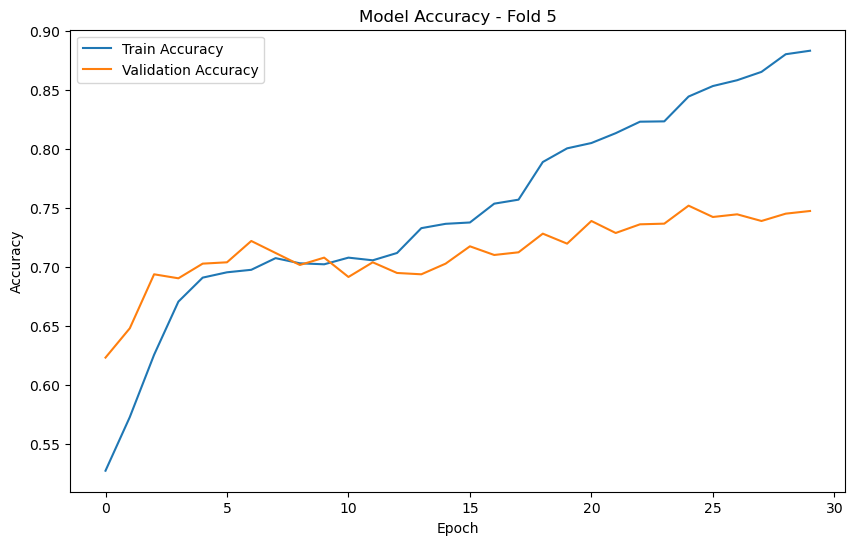

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Fold 5 Results:
Accuracy: 0.7520
Balanced Accuracy: 0.7490
MCC: 0.5068
Sensitivity: 0.8352
Specificity: 0.6628

Learned track weights for fold 5:
Sequence weight: 0.3384
Structure weight: 0.3238
ProtT5 weight: 0.3378

Average track weights across folds:
Sequence weight: 0.3396 ± 0.0198
Structure weight: 0.3203 ± 0.0050
ProtT5 weight: 0.3402 ± 0.0169

Average Cross-validation Results:
ACC: 0.7324 ± 0.0252
BALANCED_ACC: 0.7302 ± 0.0230
MCC: 0.4641 ± 0.0499
SN: 0.7713 ± 0.0547
SP: 0.6891 ± 0.0187

Final Test Set Results:
Accuracy: 0.7055
Balanced Accuracy: 0.7482
MCC: 0.2950
Sensitivity: 0.8000
Specificity: 0.6964
Confusion Matrix:
[[1739  758]
 [  48  192]]
##################################################


In [29]:
struc_window = 0
for i in range(0, 5):
    if __name__ == "__main__":
        print("Struct window: ", i)
        model = train_and_evaluate(struct_window=i)
        print("#"*50)